In [6]:
import os, re, glob, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed

# config 
data_folder = "../generated/grid_100" 
profile_dir = "../data/raw"
profile_path = os.path.join(profile_dir, "profile.CSV")
MAX_WORKERS = min(32, os.cpu_count() or 8)  # use up to 32

# load profile (no header): X in col 0, Y in col 1
profile_df = pd.read_csv(profile_path, header=None)
profile_df.columns = ["X", "Y", "_"]  # ignore 3rd col (Z)
N = len(profile_df)

# strict spectra list: files whose names end with _NNN.CSV for NNN in 001..N
spectra_files = []
for idx in range(1, N+1):
    pattern = os.path.join(data_folder, f"*_{idx:03d}.CSV")
    matches = glob.glob(pattern)
    if not matches:
        raise FileNotFoundError(f"Missing spectrum for index {idx:03d} (pattern {pattern})")
    spectra_files.append(matches[0])

print(f"Profile points: {N}, spectra files: {len(spectra_files)}")

# robust CSV loader that auto-detects header 
def load_xy_pandas(fn):
    # Try header=0; if first two columns are numeric, proceed; otherwise fallback to header=None
    try:
        df = pd.read_csv(fn, header=0)
        x = pd.to_numeric(df.iloc[:, 0], errors="coerce").to_numpy()
        y = pd.to_numeric(df.iloc[:, 1], errors="coerce").to_numpy()
        if np.isnan(x).any() or np.isnan(y).any():
            raise ValueError("NaNs after header=0 parse; retrying with header=None")
        return x, y
    except Exception:
        df = pd.read_csv(fn, header=None)
        x = pd.to_numeric(df.iloc[:, 0], errors="coerce").to_numpy()
        y = pd.to_numeric(df.iloc[:, 1], errors="coerce").to_numpy()
        # drop any rows that failed numeric parsing
        mask = ~(np.isnan(x) | np.isnan(y))
        return x[mask], y[mask]

# read the first file to get common x (only for overlay plotting)
x0, _ = load_xy_pandas(spectra_files[0])

# Parallel read of Y vectors for overlay
t0 = time.time()
Y_list = [None] * len(spectra_files)
def load_y_only(fn):
    _, y = load_xy_pandas(fn)
    return y

with ProcessPoolExecutor(max_workers=MAX_WORKERS) as ex:
    futs = {ex.submit(load_y_only, fn): i for i, fn in enumerate(spectra_files)}
    for fut in as_completed(futs):
        i = futs[fut]
        Y_list[i] = fut.result()

print(f"Loaded {len(Y_list)} spectra (Y only) in {time.time() - t0:.2f}s using {MAX_WORKERS} workers.")

# # Plot (single-threaded; quick for 100 curves). Downsample if super dense.
# plt.figure(figsize=(8, 5))
# for y in Y_list:
#     # align lengths defensively (some files might have 1-point difference after cleaning)
#     n = min(len(x0), len(y))
#     plt.plot(x0[:n], y[:n], alpha=0.35, linewidth=0.8)

# plt.gca().invert_xaxis()
# plt.xlabel("Wavenumber (cm⁻¹)")
# plt.ylabel("Absorbance")
# plt.title(f"IR spectra overlay ({len(Y_list)} points)")
# plt.tight_layout()
# plt.show()


Profile points: 100, spectra files: 100
Loaded 100 spectra (Y only) in 0.28s using 32 workers.


Extracted intensities for 100 files in 0.27s.


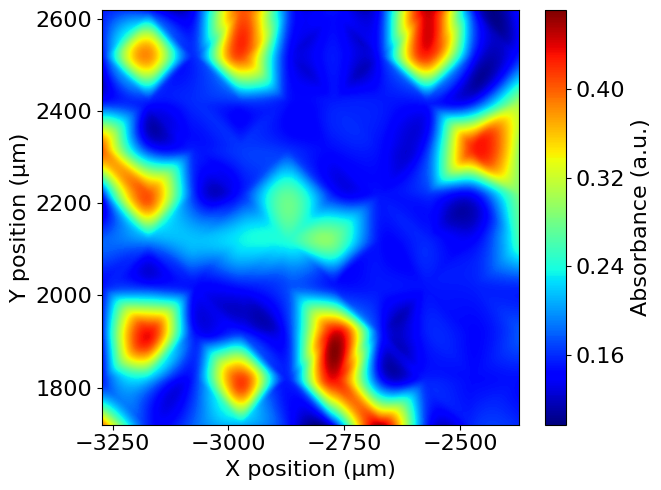

Saved: ../plots/fig_s1a_820.jpg


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.interpolate import griddata
import numpy.ma as ma
import time

# ==== map config ====
target_wavenumber = 820  # cm^-1
tolerance = 2             # cm^-1 (accept only if nearest within ±2)
GRID_N = 200              # interpolation grid resolution
MAX_WORKERS = min(32, os.cpu_count() or 8)

def extract_intensity_pandas(fn, target_wn, tol):
    # load with header autodetect (same logic as in Cell 1)
    try:
        df = pd.read_csv(fn, header=0)
        wn = pd.to_numeric(df.iloc[:,0], errors="coerce").to_numpy()
        ab = pd.to_numeric(df.iloc[:,1], errors="coerce").to_numpy()
        if np.isnan(wn).any() or np.isnan(ab).any():
            raise ValueError
    except Exception:
        df = pd.read_csv(fn, header=None)
        wn = pd.to_numeric(df.iloc[:,0], errors="coerce").to_numpy()
        ab = pd.to_numeric(df.iloc[:,1], errors="coerce").to_numpy()
        m = ~(np.isnan(wn) | np.isnan(ab))
        wn, ab = wn[m], ab[m]

    if len(wn) == 0:
        return np.nan

    j = int(np.abs(wn - target_wn).argmin())
    return float(ab[j]) if abs(wn[j] - target_wn) <= tol else np.nan

t0 = time.time()
intensities = np.full(len(spectra_files), np.nan, dtype=float)

# Parallel extraction
with ProcessPoolExecutor(max_workers=MAX_WORKERS) as ex:
    futs = {ex.submit(extract_intensity_pandas, fn, target_wavenumber, tolerance): i
            for i, fn in enumerate(spectra_files)}
    for fut in as_completed(futs):
        i = futs[fut]
        intensities[i] = fut.result()

print(f"Extracted intensities for {len(intensities)} files in {time.time() - t0:.2f}s.")

# Prepare XY
x = profile_df["X"].to_numpy()
y = profile_df["Y"].to_numpy()
z = intensities

# Interpolate
gx, gy = np.mgrid[min(x):max(x):complex(GRID_N), min(y):max(y):complex(GRID_N)]
gz = griddata((x, y), z, (gx, gy), method="cubic")
gz_mask = ma.masked_invalid(gz)

# === Spatial IR heatmap ===
plot_dir = "../plots"                     
os.makedirs(plot_dir, exist_ok=True)

plt.figure(figsize=(6.7, 5))

# --- Heatmap ---
contour = plt.contourf(
    gx, gy, gz_mask,
    levels=300,
    cmap="jet"   # you can change to 'magma', 'viridis', etc.
)

# --- Colorbar ---
cbar = plt.colorbar(contour)
cbar.set_label(f"Absorbance (a.u.)", fontsize=16)
cbar.ax.tick_params(labelsize=16)

# Format ticks to 2 decimals
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))

# Control number of ticks (example: ~5 ticks)
cbar.locator = MaxNLocator(nbins=5)
cbar.update_ticks()

# --- Axis labels ---
plt.xlabel("X position (µm)", fontsize=16)
plt.ylabel("Y position (µm)", fontsize=16)

# --- Tick font sizes and ~5 ticks per axis ---
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout()

# --- Save figure ---
path_heatmap = os.path.join(plot_dir, f"fig_s1a_820.jpg")
plt.savefig(path_heatmap, dpi=500)
plt.show()

print(f"Saved: {path_heatmap}")


Extracted intensities for 100 files in 0.26s.


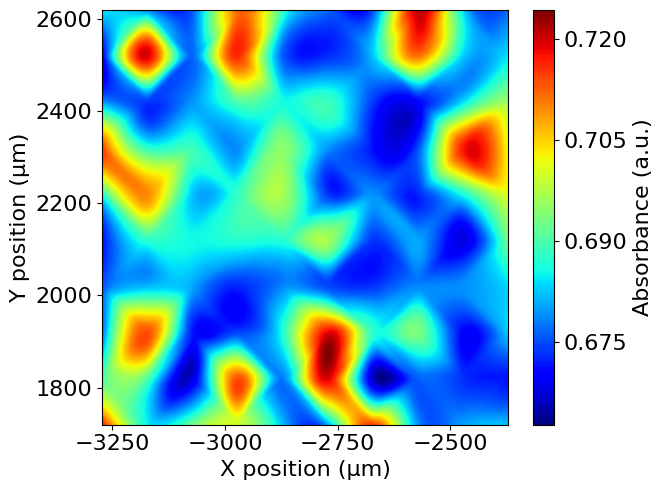

Saved: ../plots/fig_s1b_1650.jpg


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.interpolate import griddata
import numpy.ma as ma
import time

# ==== map config ====
target_wavenumber = 1650  # cm^-1
tolerance = 2             # cm^-1 (accept only if nearest within ±2)
GRID_N = 200              # interpolation grid resolution
MAX_WORKERS = min(32, os.cpu_count() or 8)

def extract_intensity_pandas(fn, target_wn, tol):
    # load with header autodetect (same logic as in Cell 1)
    try:
        df = pd.read_csv(fn, header=0)
        wn = pd.to_numeric(df.iloc[:,0], errors="coerce").to_numpy()
        ab = pd.to_numeric(df.iloc[:,1], errors="coerce").to_numpy()
        if np.isnan(wn).any() or np.isnan(ab).any():
            raise ValueError
    except Exception:
        df = pd.read_csv(fn, header=None)
        wn = pd.to_numeric(df.iloc[:,0], errors="coerce").to_numpy()
        ab = pd.to_numeric(df.iloc[:,1], errors="coerce").to_numpy()
        m = ~(np.isnan(wn) | np.isnan(ab))
        wn, ab = wn[m], ab[m]

    if len(wn) == 0:
        return np.nan

    j = int(np.abs(wn - target_wn).argmin())
    return float(ab[j]) if abs(wn[j] - target_wn) <= tol else np.nan

t0 = time.time()
intensities = np.full(len(spectra_files), np.nan, dtype=float)

# Parallel extraction
with ProcessPoolExecutor(max_workers=MAX_WORKERS) as ex:
    futs = {ex.submit(extract_intensity_pandas, fn, target_wavenumber, tolerance): i
            for i, fn in enumerate(spectra_files)}
    for fut in as_completed(futs):
        i = futs[fut]
        intensities[i] = fut.result()

print(f"Extracted intensities for {len(intensities)} files in {time.time() - t0:.2f}s.")

# Prepare XY
x = profile_df["X"].to_numpy()
y = profile_df["Y"].to_numpy()
z = intensities

# Interpolate
gx, gy = np.mgrid[min(x):max(x):complex(GRID_N), min(y):max(y):complex(GRID_N)]
gz = griddata((x, y), z, (gx, gy), method="cubic")
gz_mask = ma.masked_invalid(gz)

# === Spatial IR heatmap ===
plot_dir = "../plots"                     
os.makedirs(plot_dir, exist_ok=True)

plt.figure(figsize=(6.7, 5))

# --- Heatmap ---
contour = plt.contourf(
    gx, gy, gz_mask,
    levels=300,
    cmap="jet"   # you can change to 'magma', 'viridis', etc.
)

# --- Colorbar ---
cbar = plt.colorbar(contour)
cbar.set_label(f"Absorbance (a.u.)", fontsize=16)
cbar.ax.tick_params(labelsize=16)

# Format ticks to 2 decimals
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))

# Control number of ticks (example: ~5 ticks)
cbar.locator = MaxNLocator(nbins=5)
cbar.update_ticks()

# --- Axis labels ---
plt.xlabel("X position (µm)", fontsize=16)
plt.ylabel("Y position (µm)", fontsize=16)

# --- Tick font sizes and ~5 ticks per axis ---
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout()

# --- Save figure ---
path_heatmap = os.path.join(plot_dir, f"fig_s1b_1650.jpg")
plt.savefig(path_heatmap, dpi=500)
plt.show()

print(f"Saved: {path_heatmap}")

Extracted intensities for 100 files in 0.30s.


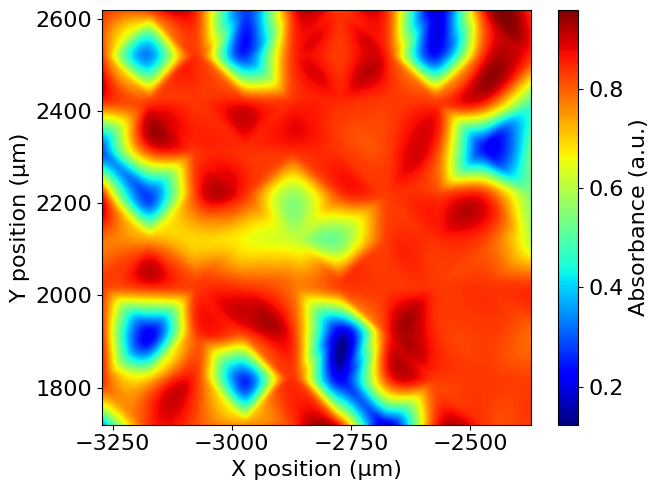

Saved: ../plots/fig_s1c_1545.jpg


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.interpolate import griddata
import numpy.ma as ma
import time

# ==== map config ====
target_wavenumber = 1545  # cm^-1
tolerance = 2             # cm^-1 (accept only if nearest within ±2)
GRID_N = 200              # interpolation grid resolution
MAX_WORKERS = min(32, os.cpu_count() or 8)

def extract_intensity_pandas(fn, target_wn, tol):
    # load with header autodetect (same logic as in Cell 1)
    try:
        df = pd.read_csv(fn, header=0)
        wn = pd.to_numeric(df.iloc[:,0], errors="coerce").to_numpy()
        ab = pd.to_numeric(df.iloc[:,1], errors="coerce").to_numpy()
        if np.isnan(wn).any() or np.isnan(ab).any():
            raise ValueError
    except Exception:
        df = pd.read_csv(fn, header=None)
        wn = pd.to_numeric(df.iloc[:,0], errors="coerce").to_numpy()
        ab = pd.to_numeric(df.iloc[:,1], errors="coerce").to_numpy()
        m = ~(np.isnan(wn) | np.isnan(ab))
        wn, ab = wn[m], ab[m]

    if len(wn) == 0:
        return np.nan

    j = int(np.abs(wn - target_wn).argmin())
    return float(ab[j]) if abs(wn[j] - target_wn) <= tol else np.nan

t0 = time.time()
intensities = np.full(len(spectra_files), np.nan, dtype=float)

# Parallel extraction
with ProcessPoolExecutor(max_workers=MAX_WORKERS) as ex:
    futs = {ex.submit(extract_intensity_pandas, fn, target_wavenumber, tolerance): i
            for i, fn in enumerate(spectra_files)}
    for fut in as_completed(futs):
        i = futs[fut]
        intensities[i] = fut.result()

print(f"Extracted intensities for {len(intensities)} files in {time.time() - t0:.2f}s.")

# Prepare XY
x = profile_df["X"].to_numpy()
y = profile_df["Y"].to_numpy()
z = intensities

# Interpolate
gx, gy = np.mgrid[min(x):max(x):complex(GRID_N), min(y):max(y):complex(GRID_N)]
gz = griddata((x, y), z, (gx, gy), method="cubic")
gz_mask = ma.masked_invalid(gz)

# === Spatial IR heatmap ===
plot_dir = "../plots"                     
os.makedirs(plot_dir, exist_ok=True)

plt.figure(figsize=(6.7, 5))

# --- Heatmap ---
contour = plt.contourf(
    gx, gy, gz_mask,
    levels=300,
    cmap="jet"   # you can change to 'magma', 'viridis', etc.
)

# --- Colorbar ---
cbar = plt.colorbar(contour)
cbar.set_label(f"Absorbance (a.u.)", fontsize=16)
cbar.ax.tick_params(labelsize=16)

# Format ticks to 2 decimals
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))

# Control number of ticks (example: ~5 ticks)
cbar.locator = MaxNLocator(nbins=5)
cbar.update_ticks()

# --- Axis labels ---
plt.xlabel("X position (µm)", fontsize=16)
plt.ylabel("Y position (µm)", fontsize=16)

# --- Tick font sizes and ~5 ticks per axis ---
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout()

# --- Save figure ---
path_heatmap = os.path.join(plot_dir, f"fig_s1c_1545.jpg")
plt.savefig(path_heatmap, dpi=500)
plt.show()

print(f"Saved: {path_heatmap}")


Extracted intensities for 100 files in 0.30s.


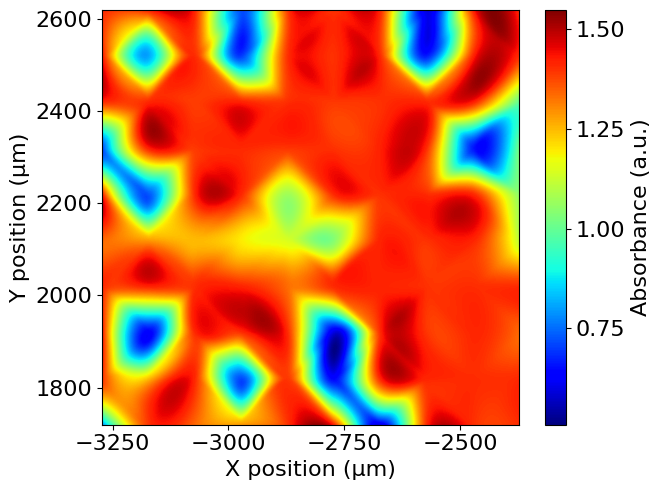

Saved: ../plots/fig_s1d_2362.jpg


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.interpolate import griddata
import numpy.ma as ma
import time

# ==== map config ====
target_wavenumber = 2362  # cm^-1
tolerance = 2             # cm^-1 (accept only if nearest within ±2)
GRID_N = 200              # interpolation grid resolution
MAX_WORKERS = min(32, os.cpu_count() or 8)

def extract_intensity_pandas(fn, target_wn, tol):
    # load with header autodetect (same logic as in Cell 1)
    try:
        df = pd.read_csv(fn, header=0)
        wn = pd.to_numeric(df.iloc[:,0], errors="coerce").to_numpy()
        ab = pd.to_numeric(df.iloc[:,1], errors="coerce").to_numpy()
        if np.isnan(wn).any() or np.isnan(ab).any():
            raise ValueError
    except Exception:
        df = pd.read_csv(fn, header=None)
        wn = pd.to_numeric(df.iloc[:,0], errors="coerce").to_numpy()
        ab = pd.to_numeric(df.iloc[:,1], errors="coerce").to_numpy()
        m = ~(np.isnan(wn) | np.isnan(ab))
        wn, ab = wn[m], ab[m]

    if len(wn) == 0:
        return np.nan

    j = int(np.abs(wn - target_wn).argmin())
    return float(ab[j]) if abs(wn[j] - target_wn) <= tol else np.nan

t0 = time.time()
intensities = np.full(len(spectra_files), np.nan, dtype=float)

# Parallel extraction
with ProcessPoolExecutor(max_workers=MAX_WORKERS) as ex:
    futs = {ex.submit(extract_intensity_pandas, fn, target_wavenumber, tolerance): i
            for i, fn in enumerate(spectra_files)}
    for fut in as_completed(futs):
        i = futs[fut]
        intensities[i] = fut.result()

print(f"Extracted intensities for {len(intensities)} files in {time.time() - t0:.2f}s.")

# Prepare XY
x = profile_df["X"].to_numpy()
y = profile_df["Y"].to_numpy()
z = intensities

# Interpolate
gx, gy = np.mgrid[min(x):max(x):complex(GRID_N), min(y):max(y):complex(GRID_N)]
gz = griddata((x, y), z, (gx, gy), method="cubic")
gz_mask = ma.masked_invalid(gz)

# === Spatial IR heatmap ===
plot_dir = "../plots"                     
os.makedirs(plot_dir, exist_ok=True)

plt.figure(figsize=(6.7, 5))

# --- Heatmap ---
contour = plt.contourf(
    gx, gy, gz_mask,
    levels=300,
    cmap="jet"   # you can change to 'magma', 'viridis', etc.
)

# --- Colorbar ---
cbar = plt.colorbar(contour)
cbar.set_label(f"Absorbance (a.u.)", fontsize=16)
cbar.ax.tick_params(labelsize=16)

# Format ticks to 2 decimals
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))

# Control number of ticks (example: ~5 ticks)
cbar.locator = MaxNLocator(nbins=5)
cbar.update_ticks()

# --- Axis labels ---
plt.xlabel("X position (µm)", fontsize=16)
plt.ylabel("Y position (µm)", fontsize=16)

# --- Tick font sizes and ~5 ticks per axis ---
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout()

# --- Save figure ---
path_heatmap = os.path.join(plot_dir, f"fig_s1d_2362.jpg")
plt.savefig(path_heatmap, dpi=500)
plt.show()

print(f"Saved: {path_heatmap}")
